In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FormatStrFormatter

In [3]:
from pathlib import Path
from rich.jupyter import print
from matplotlib.patches import Patch
from ase.tools.utils import export_legend

# ASE: Graph Environment Results

This notebook renders the results of the graph experiments. The results are expected to be found within `./results/graph` sub-directory. To replicate them, it suffices to run:

```txt
python -m ase.scripts.graph_experiment 8854 \
    --artifacts-dir results/graph/ \
    --tcfe-threshold 0.75 \
    --num-trajectories 500 \
    --num-agents 6 \
    --num-cf-samples 100 \
    --num-effect-agents-choices 31 \
    --posterior-sample-complexity 500
```

In [4]:
_ = sns.set_theme(
    style="white", context="paper",
    palette="muted",
    rc={
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
        "font.size": 25,
        "axes.titlesize": 25,
        "axes.labelsize": 25,
        "xtick.labelsize": 20,
        "ytick.labelsize": 20,
        "legend.fontsize": 20,
        "legend.columnspacing": 1,
        "legend.title_fontsize": 20,
        "figure.figsize": (6.4, 6.4),
    },
)

In [5]:
seed = 8854
results_dir = Path("./results/graph")
plots_dir = Path("./results/plots/graph")

## Render Configuration

In this section we define properties of generate plots.

In [6]:
plt_skip_legend = True

plt_palette_quantities = {"cf-ASE": "#009a5b", "cf-PSE": "#de281b"}

plt_ase_ranges_palette_num_effect_agents = {1: "#fe157e", 2: "#22a0c1", 3: "#b9b3d6", 4: "#006d91", 5: "#eb76b7"}
plt_ase_ranges_title = None
plt_ase_ranges_legend_title = "Agent id"
plt_ase_ranges_x_label = "cf-ASE Value Ranges"
plt_ase_ranges_y_label = "Percentage %"

plt_prob_robustness_palette_err_max = {0.01: "#ffbf82", 0.02: "#fa9072", 0.05: "#eb5e5f", 0.1: "#dd2d5a", 0.15: "#b51d65", 0.2: "#75045d"}
plt_prob_robustness_title = None
plt_prob_robustness_legend_title = None
plt_prob_robustness_x_label = "Target Value Ranges"
plt_prob_robustness_y_label = "Avg. Absolute Error"

plt_order_robustness_palette_order = {
    "up,straight,down": "#0074a3",
    "down,straight,up": "#0098d7",

    "down,up,straight": "#a15ab3",
    "straight,up,down": "#713580",

    "straight,down,up": "#00cb77",
}
plt_order_robustness_title = None
plt_order_robustness_legend_title = None
plt_order_robustness_x_label = "Target Value Ranges"
plt_order_robustness_y_label = "Avg. Absolute Error"

plt_complexity_palette_quantity = {"tcfe": "#0086be", "ase": "#009a5b", "pse": "#de281b"}
plt_complexity_title = None
plt_complexity_legend_title = None
plt_complexity_x_label = "Number of CF samples"
plt_complexity_y_label = "Frac. of converged interventions"

## Trajectory Sampling

To start out analysis, we sample $500$ trajectories that have had a **failed** outcome.

In [7]:
trajectories = pickle.load(open(results_dir / str(seed) / "trajectories.pkl", "rb"))
print(f"Loaded {len(trajectories)} trajectories.")

Loaded 500 trajectories.

## Baseline Analysis

We calculate the ground-truth ASE, for every possible combination of effect agents. We assume **correct** access to the underlying agent's probabilities and total order.

### Enumerating Counterfactuals

For each trajectory, agent, time-step and executed action of that agent, we enumerate all possible alternative actions an agent could have taken, calculating their TCFE. The obtained data-frame has following columns:
- `traj_id`: unique identifier of the trajectory where the intervention has been made
- `agent_id`: unique identifier of the agent for which we consider the intervention
- `time_step`: time-step of the trajectory where the intervention happened
- `alternative`: alternative action the agent has taken (different than one from the trajectory)
- `tcfe`: total counterfactual effect of the made intervention on the outcome

The data-frame is shown below.

In [8]:
df = pd.read_csv(results_dir / str(seed) / "counterfactuals.csv")
df

,traj_id,agent_id,time_step,alternative,tcfe
0,0,0,0,0,0.09
1,0,0,0,2,0.01
2,0,1,0,0,0.03
3,0,1,0,2,0.03
4,0,2,0,1,0.15
...,...,...,...,...,...
14423,499,3,2,0,1.00
14424,499,4,2,1,0.00
14425,499,4,2,2,0.00
14426,499,5,2,0,1.00


### ASE Analysis

We are interested in interventions that happened in time-steps 0, 1 and 2, giving a total counterfactual effect of $\ge 0.75$. For those interventions, we calculate ASE for every possible combination of the effect agents. Because we have $6$ agents in total, we consider all possible combinations of the remaining $5$ agents which amounts to:
$$
{5 \choose 5} + {5 \choose 4} + {5 \choose 3} + {5 \choose 2} + {5 \choose 1} = 31
$$

The ASE results are part of the columns named in the format `ase_ag1,ag2...`, except for the case where we consider all $5$ agents, when the column is simply named `ase_total`. The `NaN` columns indicate that ASE for that particular combination of agents was not calculate for the intervention in question (this is the case only for combinations that contain the agent which made the intervention).

In [9]:
df = pd.read_csv(results_dir / str(seed) / "counterfactuals_w_ase.csv")
df

,traj_id,agent_id,time_step,alternative,tcfe,ase_ag0,ase_ag1,ase_ag3,ase_ag4,ase_ag5,...,"ase_ag0,ag1,ag2","ase_ag0,ag2,ag3","ase_ag0,ag2,ag5","ase_ag0,ag1,ag2,ag3","ase_ag0,ag1,ag2,ag5","ase_ag0,ag2,ag3,ag5","ase_ag0,ag2,ag4","ase_ag0,ag2,ag3,ag4","ase_ag0,ag2,ag4,ag5","ase_ag0,ag1,ag2,ag4"
0,1,2,0,0,0.79,0.97,0.03,0.0,0.0,0.06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0,1,1,0.83,NaN,0.10,0.0,0.0,0.04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,4,1,1,0.79,0.00,0.04,0.0,NaN,0.11,...,0.0,0.0,0.0,0.0,0.01,0.0,NaN,NaN,NaN,NaN
3,1,1,2,1,1.00,0.00,NaN,0.0,0.0,0.00,...,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN
4,1,5,2,2,1.00,0.00,0.00,0.0,0.0,NaN,...,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
849,499,5,1,0,0.87,0.00,0.00,0.0,0.0,NaN,...,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0,NaN,0.0
850,499,5,1,2,1.00,0.00,0.00,0.0,0.0,NaN,...,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0,NaN,0.0
851,499,0,2,0,1.00,NaN,0.00,0.0,0.0,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
852,499,3,2,0,1.00,0.00,0.00,NaN,0.0,0.00,...,0.0,NaN,0.0,NaN,0.00,NaN,0.0,NaN,0.0,0.0


## Descriptive Statistics

To obtain a better understanding of the selected counterfactuals, we next visualize their distribution. The following plot groups the ASE by the number of effect agents considered, and displays its value binned into the following groups [0.0, 0.25], (0.25, 0.50], (0.50, 0.75], (0.75, 1.0].

In [10]:
df_curr = df.copy()
df_curr = df_curr.melt(["traj_id", "time_step", "agent_id", "alternative", "tcfe"], var_name="effect_agents", value_name="ase")
df_curr["effect_agents_count"] = [5 if ea_label == "ase_total" else len(ea_label.split("_")[1].split(",")) for ea_label in df_curr.effect_agents]
df_curr = df_curr.dropna(axis=0)
df_curr.ase = pd.cut(df_curr.ase, bins=[0.0, 0.25, 0.5, 0.75, 1.0], labels=["[.0, .25]", "(.25, .5]", "(.5, .75]", "(.75, 1.0]"], include_lowest=True)

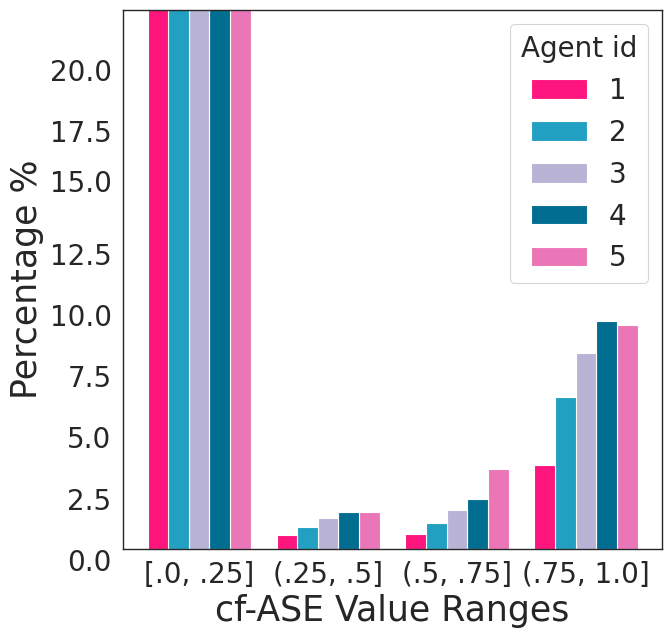

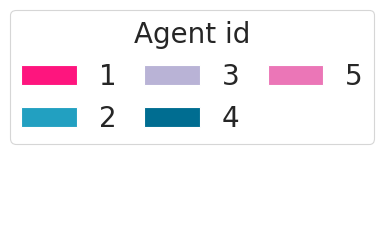

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
_ = sns.histplot(data=df_curr, x="ase", hue="effect_agents_count", stat="percent", palette=plt_ase_ranges_palette_num_effect_agents, multiple="dodge", shrink=0.8, alpha=1.0, ax=ax, discrete=True, cumulative=False, common_norm=False)
_ = ax.set_title(plt_ase_ranges_title)
_ = ax.set_ylim(0, 100)
_ = ax.get_legend().set_title(plt_ase_ranges_legend_title)
_ = ax.set_xlabel(plt_ase_ranges_x_label)
_ = ax.set_ylabel(plt_ase_ranges_y_label)
_ = [a.set_va("top") for a in ax.get_yticklabels()]
_ = ax.set_box_aspect(1)
_ = ax.set_ylim(0, 22)

# separately exports legend
legend_fig, legend = export_legend(fig, ax)
legend_fig.savefig(plots_dir / "appendix" / "legends" / "ase_ranges.pdf", bbox_inches=legend.get_window_extent().transformed(legend_fig.dpi_scale_trans.inverted()), bbox_extra_artists=[legend])

# export plot without legend
# if plt_skip_legend: _ = ax.get_legend().remove()
fig.savefig(plots_dir / "appendix" / "ase_ranges" / f"ase_ranges.pdf", bbox_inches="tight")

## Robustness Analysis

In this section, we showcases the results of ASE computation when faced with (i) error in assumed agent's probabilities and (ii) misspecified total order.

### Error Robustness

We calculate the difference between ground-truth ASE (calculated with true probabilities $p_i$) and ASE calculated with probability error. The erroneous probabilities are sampled from a range $[p_i - e_{max}, p_i + e_{max}]$, for each agent $i$. We consider the following values for $e_{max} \in \{0.01, 0.02, 0.05, 0.1, 0.15, 0.2\}$. To estimate the overall error, we calculate the absolute difference between ground-truth values and values calculated with probability error, repeating the procedure for all $31$ possible effect agents. The resulting data-frame contains the following additional columns:
- `int_id`: unique id of intervention
- `err_max`: the $e_{max}$ error used in agent's probabilities 
- `ase_type`: list of the effects agents used to calculate ASE
- `ase_true`: ground-truth value of ASE, without error
- `ase_w_error`: value of ASE, calculated with probability error

The data-frame is shown below.

In [12]:
df = pd.read_csv(results_dir / str(seed) / "counterfactuals_w_ase_prob_error.csv")
df

,traj_id,agent_id,int_id,err_max,ase_type,ase_true,ase_w_error,tcfe,time_step,alternative
0,1,2,0,0.01,"ase_ag0,ag3,ag4",0.21,0.23,0.79,0,0
1,1,2,0,0.01,"ase_ag0,ag3,ag5",0.90,0.90,0.79,0,0
2,1,2,0,0.01,"ase_ag0,ag1,ag5",0.91,0.87,0.79,0,0
3,1,2,0,0.01,"ase_ag1,ag3,ag4,ag5",0.02,0.04,0.79,0,0
4,1,2,0,0.01,"ase_ag4,ag5",0.01,0.03,0.79,0,0
...,...,...,...,...,...,...,...,...,...,...
158839,499,5,853,0.20,"ase_ag1,ag2",0.00,0.05,1.00,2,0
158840,499,5,853,0.20,"ase_ag3,ag4",0.00,0.06,1.00,2,0
158841,499,5,853,0.20,"ase_ag0,ag1,ag3",0.00,0.07,1.00,2,0
158842,499,5,853,0.20,"ase_ag0,ag2",0.00,0.08,1.00,2,0


Next, we calculate the **absolute error** between ground-truth ASE and ASE calculated with probability error.

In [13]:
df_abs = df.copy()
df_abs["ase_error"] = abs(df_abs["ase_w_error"] - df_abs["ase_true"])
df_abs["ase_true"] = pd.cut(df_abs["ase_true"], bins=[0.0, 0.25, 0.5, 0.75, 1.0], labels=["[.0, .25]", "(.25, .5]", "(.5, .75]", "(.75, 1.0]"], include_lowest=True)

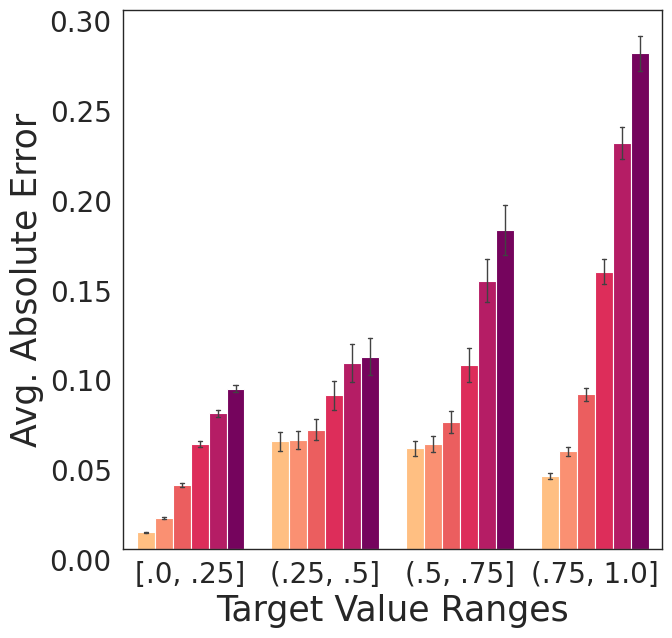

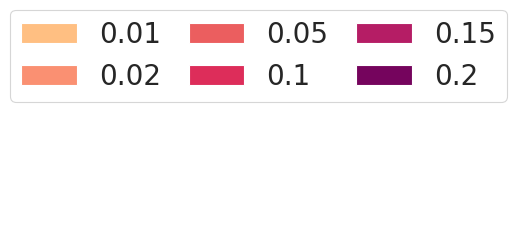

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
legend_fig.savefig(plots_dir / "legends" / "order_robustness.pdf", bbox_inches=legend.get_window_extent().transformed(legend_fig.dpi_scale_trans.inverted()), bbox_extra_artists=[legend])
_ = sns.barplot(data=df_abs, x="ase_true", y="ase_error", errorbar=("se", 2), hue="err_max", palette=plt_prob_robustness_palette_err_max, ax=ax, errwidth=1, saturation=1.0, capsize=0.03)
_ = ax.set_title(plt_prob_robustness_title)
_ = ax.get_legend().set_title(plt_prob_robustness_legend_title)
_ = ax.set_xlabel(plt_prob_robustness_x_label)
_ = ax.set_ylim(0.0, 0.3)
_ = [a.set_va("top") for a in ax.get_yticklabels()]
_ = ax.set_box_aspect(1)
_ = ax.set_ylabel(plt_prob_robustness_y_label)

# separately exports legend
legend_fig, legend = export_legend(fig, ax)
legend_fig.savefig(plots_dir / "legends" / "prob_robustness.pdf", bbox_inches=legend.get_window_extent().transformed(legend_fig.dpi_scale_trans.inverted()), bbox_extra_artists=[legend])

# exports plot without legend
if plt_skip_legend: _ = ax.get_legend().remove()
fig.savefig(plots_dir / "prob_robustness" / f"prob_robustness.pdf", bbox_inches="tight")

### Total Order Robustness

In this section, we demonstrate behavior of ASE for misspecified total order. We try out all $5$ alternative total orders and, for each intervention, calculate the ASE value for every possible combination of the effect agents, exactly the same as for probability robustness. The resulting data-frame columns have the same values as in the previous section, with an addition of the `order` column which indicates the used order.

In [15]:
df = pd.read_csv(results_dir / str(seed) / "counterfactuals_w_ase_order_error.csv")
df

,traj_id,agent_id,int_id,order,ase_type,ase_true,ase_w_error,tcfe,time_step,alternative
0,1,2,0,"0, 2, 1","ase_ag0,ag1,ag3",0.92,0.33,0.79,0,0
1,1,2,0,"0, 2, 1","ase_ag0,ag1,ag4",0.17,0.17,0.79,0,0
2,1,2,0,"0, 2, 1",ase_total,0.22,0.14,0.79,0,0
3,1,2,0,"0, 2, 1","ase_ag0,ag1,ag3,ag4",0.23,0.16,0.79,0,0
4,1,2,0,"0, 2, 1","ase_ag0,ag3,ag5",0.90,0.60,0.79,0,0
...,...,...,...,...,...,...,...,...,...,...
132365,499,5,853,"2, 1, 0","ase_ag0,ag4",0.00,0.00,1.00,2,0
132366,499,5,853,"2, 1, 0","ase_ag0,ag3,ag4",0.00,0.00,1.00,2,0
132367,499,5,853,"2, 1, 0",ase_ag2,0.00,0.00,1.00,2,0
132368,499,5,853,"2, 1, 0","ase_ag1,ag3",0.00,0.00,1.00,2,0


We calculate  the **absolute error** compared to the ground-truth ASE.

In [16]:
df_abs = df.copy()
df_abs["ase_error"] = abs(df_abs["ase_w_error"] - df_abs["ase_true"])
df_abs["ase_true"] = pd.cut(df_abs["ase_true"], bins=[0.0, 0.25, 0.5, 0.75, 1.0], labels=["[.0, .25]", "(.25, .5]", "(.5, .75]", "(.75, 1.0]"], include_lowest=True)
df_abs.order = df_abs.order.astype("category")
df_abs.order = df_abs.order.cat.rename_categories({
    "0, 2, 1": "up,straight,down",
    "1, 0, 2": "down,up,straight",
    "1, 2, 0": "down,straight,up",
    "2, 0, 1": "straight,up,down",
    "2, 1, 0": "straight,down,up",
})

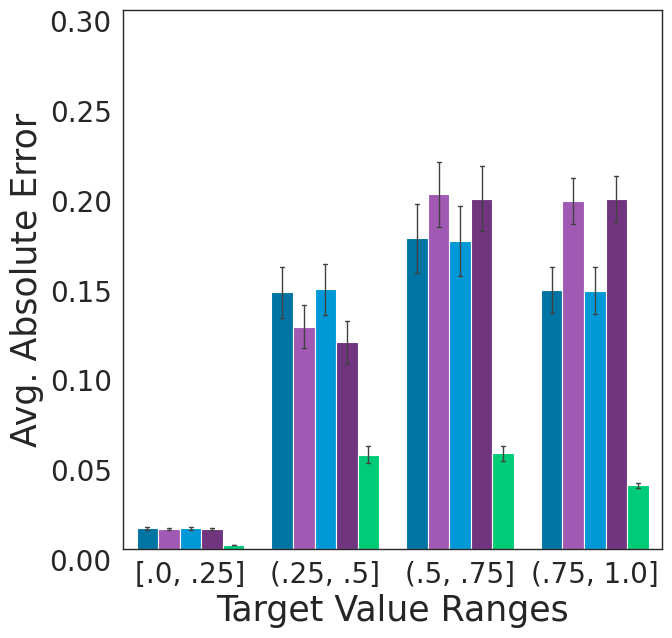

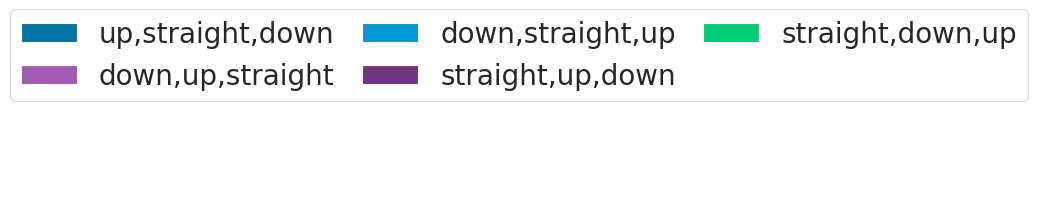

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
_ = sns.barplot(data=df_abs, x="ase_true", y="ase_error", errorbar=("se", 2), hue="order", palette=plt_order_robustness_palette_order, ax=ax, errwidth=1, saturation=1.0, capsize=0.03)
_ = ax.set_title(plt_order_robustness_title)
_ = ax.get_legend().set_title(plt_order_robustness_legend_title)
_ = ax.set_xlabel(plt_order_robustness_x_label)
_ = ax.set_ylim(0.0, 0.3)
_ = [a.set_va("top") for a in ax.get_yticklabels()]
_ = ax.set_box_aspect(1)
_ = ax.set_ylabel(plt_order_robustness_y_label)

# separately exports legend
legend_fig, legend = export_legend(fig, ax)
legend_fig.savefig(plots_dir / "legends" / "order_robustness.pdf", pad_inches=5, bbox_inches=legend.get_tightbbox().transformed(legend_fig.dpi_scale_trans.inverted()), bbox_extra_artists=[legend])

# exports plot without legend
if plt_skip_legend: _ = ax.get_legend().remove()
fig.savefig(plots_dir / "order_robustness" / "order_robustness.pdf", bbox_inches="tight")

## Sample Complexity

In this section, we empirically showcase convergence of ASE and TCFE, for different number of posterior samples. In our analysis, we consider the candidates $[10, 20, ..., 100]$. For each candidate, we calculate (total) ASE and TCFE for a subset of $500$ randomly selected interventions, across $10$ different random seeds. Then, for each candidate, we plot percentage of interventions whose variance across seeds is smaller or equal to $\epsilon=0.01$.

In [18]:
df_complexity = pd.read_csv(results_dir / str(seed) / "sample_complexity_analysis.csv")
df_complexity

,intr_id,seed,num_cf_samples,tcfe,ase
0,0,3582,10,0.10,0.00
1,1,3582,10,1.00,0.00
2,2,3582,10,0.00,0.00
3,3,3582,10,0.00,0.00
4,4,3582,10,0.50,0.00
...,...,...,...,...,...
49995,495,41070,100,0.08,0.30
49996,496,41070,100,0.23,0.44
49997,497,41070,100,0.03,0.04
49998,498,41070,100,0.82,0.03


In [19]:
eps = 0.01

In [20]:
df_curr = df_complexity.groupby(["intr_id", "num_cf_samples"]).var().reset_index()
df_curr.tcfe = (df_curr.tcfe <= eps).astype(int)
df_curr.ase = (df_curr.ase <= eps).astype(int)

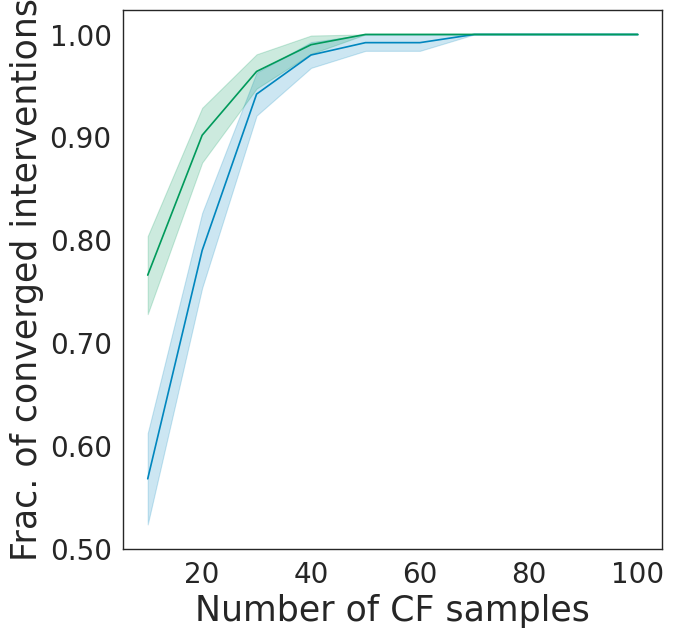

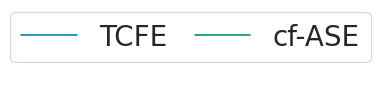

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(8, 7))
_ = sns.lineplot(data=df_curr, x="num_cf_samples", y="tcfe", label="TCFE", errorbar=("se", 2), color=plt_complexity_palette_quantity["tcfe"], ax=ax)
_ = sns.lineplot(data=df_curr, x="num_cf_samples", y="ase", label="cf-ASE", errorbar=("se", 2), color=plt_complexity_palette_quantity["ase"], ax=ax)
_ = ax.set_title(plt_complexity_title)
_ = ax.set_ylabel(plt_complexity_y_label)
_ = ax.set_xlabel(plt_complexity_x_label)
_ = ax.set_box_aspect(1)
_ = ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
_ = ax.get_legend().set_title(plt_complexity_legend_title)

# separately exports legend
legend_fig, legend = export_legend(fig, ax)
legend_fig.savefig(plots_dir / "appendix" / "legends" / "sample_complexity.pdf", bbox_inches=legend.get_window_extent().transformed(legend_fig.dpi_scale_trans.inverted()), bbox_extra_artists=[legend])

# exports plot without legend
if plt_skip_legend: _ = ax.get_legend().remove()
fig.savefig(plots_dir / "appendix" / "sample_complexity" / "sample_complexity.pdf", bbox_inches="tight")

## Legend Plot

Although we export individually each legend, we also export a single legend with all needed labels.

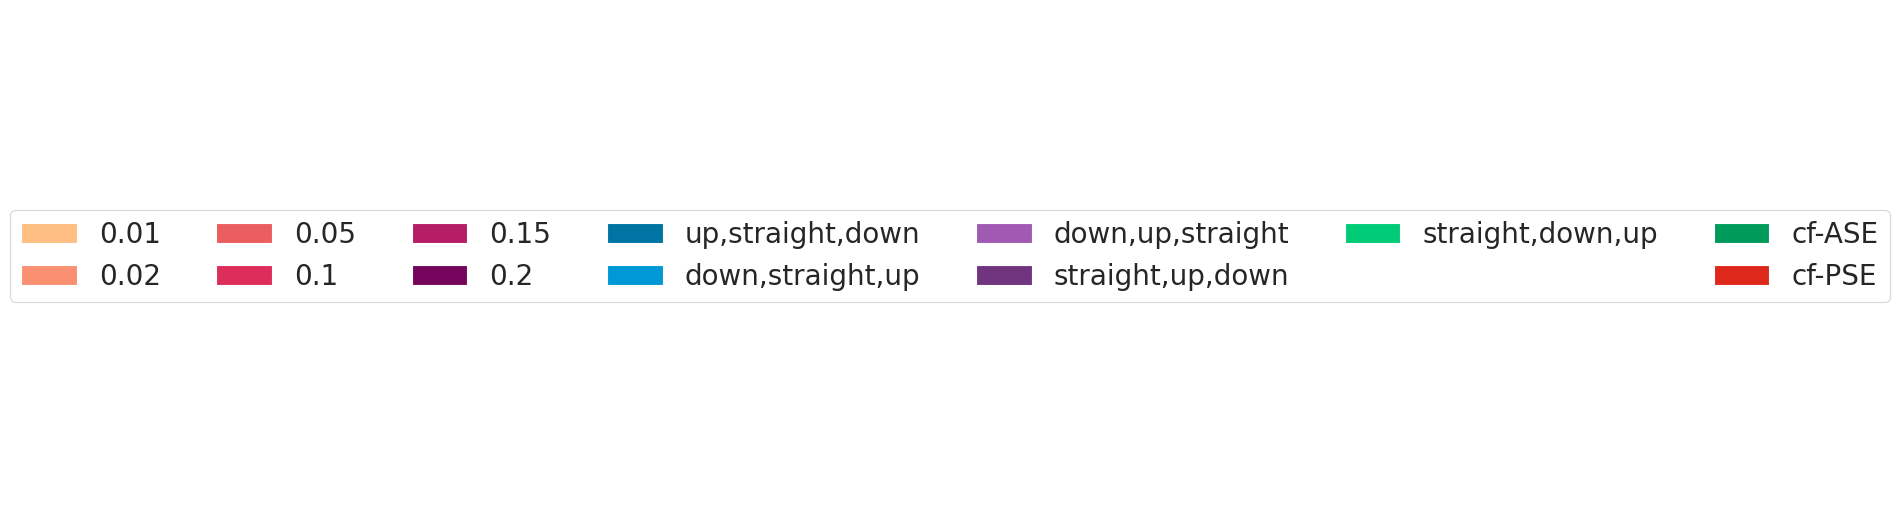

In [22]:
handles = [
    *(Patch(facecolor=v, edgecolor=None, label=k) for k, v in plt_prob_robustness_palette_err_max.items()),
    *(Patch(facecolor=v, edgecolor=None, label=k) for k, v in plt_order_robustness_palette_order.items()),
    Patch(facecolor="w", edgecolor=None, label=""),
    *(Patch(facecolor=v, edgecolor=None, label=k) for k, v in plt_palette_quantities.items()),
]
fig, ax = plt.subplots()
ax.legend(handles=handles, loc="center", ncol=7, columnspacing=2, fontsize=20)
ax.axis("off")
fig.savefig(Path("./results") / "plots" / "legends" / "main.pdf", bbox_inches=ax.get_legend().get_window_extent().transformed(legend_fig.dpi_scale_trans.inverted()), bbox_extra_artists=[ax.get_legend()])